# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

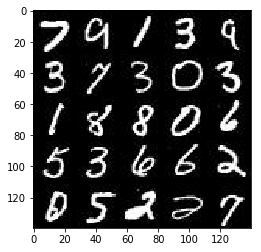

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

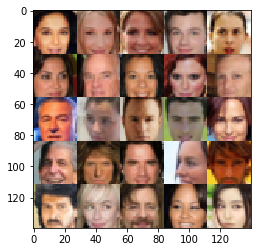

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels ), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="lr")


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 32, 3, strides=2,padding='same',use_bias=False, activation=None)
        #leaky relu
        relu1 = leaky_relu(x1)
        #relu1 = tf.nn.dropout(x1, 0.30)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 64, 3, strides=2, padding='same',use_bias=False, activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        #leaky relu
        relu2 = leaky_relu(bn2)
        #relu2 = tf.nn.dropout(relu2, 0.30)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 128, 3, strides=2, padding='same',use_bias=False, activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        #leaky relu
        relu3 = leaky_relu(bn3)
        #relu3 = tf.nn.dropout(relu3, 0.30)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        #flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,use_bias=False, activation=None)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same',use_bias=False, activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x128 now
       
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same',use_bias=False, activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x2 = leaky_relu(x2)
        #28x28x64
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28, 28))
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
   # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)   
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={lr:learning_rate, input_real:batch_images , input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr: learning_rate,input_real:batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr: learning_rate,input_real:batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,20, input_z, data_shape[3], data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 Discriminator Loss: 0.3561... Generator Loss: 1.5883
Epoch 1/2... Step 20 Discriminator Loss: 1.4153... Generator Loss: 0.4261
Epoch 1/2... Step 30 Discriminator Loss: 0.7114... Generator Loss: 0.8656
Epoch 1/2... Step 40 Discriminator Loss: 0.5708... Generator Loss: 0.9599
Epoch 1/2... Step 50 Discriminator Loss: 0.3580... Generator Loss: 1.4110
Epoch 1/2... Step 60 Discriminator Loss: 0.1222... Generator Loss: 2.5696
Epoch 1/2... Step 70 Discriminator Loss: 0.0686... Generator Loss: 3.1490
Epoch 1/2... Step 80 Discriminator Loss: 0.0640... Generator Loss: 3.0770
Epoch 1/2... Step 90 Discriminator Loss: 0.0435... Generator Loss: 3.4727
Epoch 1/2... Step 100 Discriminator Loss: 0.1529... Generator Loss: 2.5897


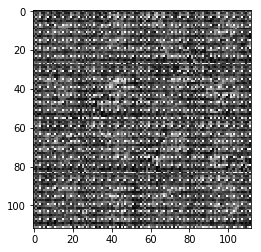

Epoch 1/2... Step 110 Discriminator Loss: 0.1944... Generator Loss: 3.2546
Epoch 1/2... Step 120 Discriminator Loss: 0.1267... Generator Loss: 2.4238
Epoch 1/2... Step 130 Discriminator Loss: 0.1338... Generator Loss: 2.3894
Epoch 1/2... Step 140 Discriminator Loss: 0.0659... Generator Loss: 3.2629
Epoch 1/2... Step 150 Discriminator Loss: 0.0197... Generator Loss: 4.6671
Epoch 1/2... Step 160 Discriminator Loss: 0.1082... Generator Loss: 2.4748
Epoch 1/2... Step 170 Discriminator Loss: 0.0649... Generator Loss: 3.0080
Epoch 1/2... Step 180 Discriminator Loss: 0.0469... Generator Loss: 3.3434
Epoch 1/2... Step 190 Discriminator Loss: 0.0650... Generator Loss: 3.0105
Epoch 1/2... Step 200 Discriminator Loss: 0.0532... Generator Loss: 3.3142


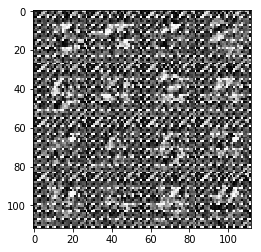

Epoch 1/2... Step 210 Discriminator Loss: 0.0542... Generator Loss: 3.2348
Epoch 1/2... Step 220 Discriminator Loss: 0.6185... Generator Loss: 0.8689
Epoch 1/2... Step 230 Discriminator Loss: 2.6699... Generator Loss: 0.0859
Epoch 1/2... Step 240 Discriminator Loss: 1.5732... Generator Loss: 0.6821
Epoch 1/2... Step 250 Discriminator Loss: 1.6608... Generator Loss: 0.2839
Epoch 1/2... Step 260 Discriminator Loss: 1.4297... Generator Loss: 0.8935
Epoch 1/2... Step 270 Discriminator Loss: 1.2441... Generator Loss: 1.1913
Epoch 1/2... Step 280 Discriminator Loss: 1.4377... Generator Loss: 0.5468
Epoch 1/2... Step 290 Discriminator Loss: 1.5912... Generator Loss: 0.7408
Epoch 1/2... Step 300 Discriminator Loss: 1.5972... Generator Loss: 0.3237


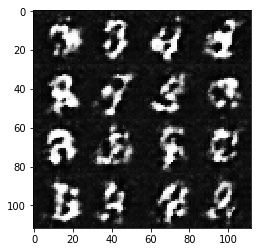

Epoch 1/2... Step 310 Discriminator Loss: 1.4778... Generator Loss: 0.3903
Epoch 1/2... Step 320 Discriminator Loss: 1.6615... Generator Loss: 0.2807
Epoch 1/2... Step 330 Discriminator Loss: 1.6748... Generator Loss: 0.2597
Epoch 1/2... Step 340 Discriminator Loss: 1.8461... Generator Loss: 0.2240
Epoch 1/2... Step 350 Discriminator Loss: 1.4204... Generator Loss: 0.4817
Epoch 1/2... Step 360 Discriminator Loss: 1.7482... Generator Loss: 0.2719
Epoch 1/2... Step 370 Discriminator Loss: 1.3722... Generator Loss: 0.5338
Epoch 1/2... Step 380 Discriminator Loss: 1.3888... Generator Loss: 0.7326
Epoch 1/2... Step 390 Discriminator Loss: 1.4862... Generator Loss: 0.9502
Epoch 1/2... Step 400 Discriminator Loss: 2.0447... Generator Loss: 0.1735


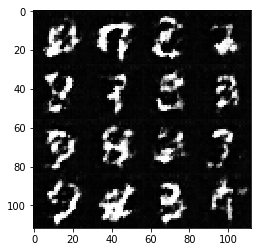

Epoch 1/2... Step 410 Discriminator Loss: 1.7126... Generator Loss: 0.2663
Epoch 1/2... Step 420 Discriminator Loss: 1.7244... Generator Loss: 0.2926
Epoch 1/2... Step 430 Discriminator Loss: 2.3283... Generator Loss: 0.1234
Epoch 1/2... Step 440 Discriminator Loss: 1.6781... Generator Loss: 0.3007
Epoch 1/2... Step 450 Discriminator Loss: 1.4052... Generator Loss: 0.5379
Epoch 1/2... Step 460 Discriminator Loss: 1.9992... Generator Loss: 0.1878
Epoch 1/2... Step 470 Discriminator Loss: 1.5717... Generator Loss: 0.3795
Epoch 1/2... Step 480 Discriminator Loss: 2.1139... Generator Loss: 0.1610
Epoch 1/2... Step 490 Discriminator Loss: 1.3990... Generator Loss: 0.5298
Epoch 1/2... Step 500 Discriminator Loss: 1.4811... Generator Loss: 0.9270


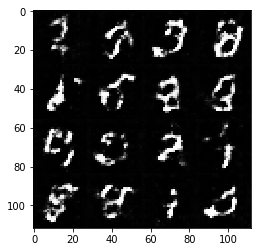

Epoch 1/2... Step 510 Discriminator Loss: 1.5647... Generator Loss: 0.3869
Epoch 1/2... Step 520 Discriminator Loss: 1.5021... Generator Loss: 0.3935
Epoch 1/2... Step 530 Discriminator Loss: 1.6147... Generator Loss: 0.3230
Epoch 1/2... Step 540 Discriminator Loss: 1.5400... Generator Loss: 0.5228
Epoch 1/2... Step 550 Discriminator Loss: 1.8645... Generator Loss: 0.2649
Epoch 1/2... Step 560 Discriminator Loss: 2.3740... Generator Loss: 0.1196
Epoch 1/2... Step 570 Discriminator Loss: 1.9687... Generator Loss: 0.1971
Epoch 1/2... Step 580 Discriminator Loss: 2.0041... Generator Loss: 0.1895
Epoch 1/2... Step 590 Discriminator Loss: 2.6155... Generator Loss: 0.0902
Epoch 1/2... Step 600 Discriminator Loss: 1.5174... Generator Loss: 0.5813


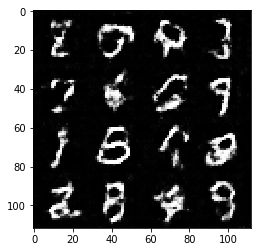

Epoch 1/2... Step 610 Discriminator Loss: 2.1001... Generator Loss: 0.1671
Epoch 1/2... Step 620 Discriminator Loss: 2.1654... Generator Loss: 0.1505
Epoch 1/2... Step 630 Discriminator Loss: 1.4078... Generator Loss: 0.3916
Epoch 1/2... Step 640 Discriminator Loss: 2.0034... Generator Loss: 0.2149
Epoch 1/2... Step 650 Discriminator Loss: 1.4122... Generator Loss: 0.8353
Epoch 1/2... Step 660 Discriminator Loss: 2.2048... Generator Loss: 0.1693
Epoch 1/2... Step 670 Discriminator Loss: 1.3320... Generator Loss: 0.8042
Epoch 1/2... Step 680 Discriminator Loss: 1.0161... Generator Loss: 2.2215
Epoch 1/2... Step 690 Discriminator Loss: 2.0332... Generator Loss: 0.1793
Epoch 1/2... Step 700 Discriminator Loss: 1.8859... Generator Loss: 0.2189


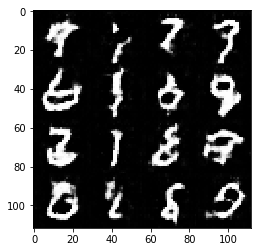

Epoch 1/2... Step 710 Discriminator Loss: 1.9569... Generator Loss: 0.2197
Epoch 1/2... Step 720 Discriminator Loss: 1.5589... Generator Loss: 0.4479
Epoch 1/2... Step 730 Discriminator Loss: 1.1992... Generator Loss: 0.7602
Epoch 1/2... Step 740 Discriminator Loss: 1.9779... Generator Loss: 0.2143
Epoch 1/2... Step 750 Discriminator Loss: 1.6220... Generator Loss: 0.3176
Epoch 1/2... Step 760 Discriminator Loss: 1.2670... Generator Loss: 0.8347
Epoch 1/2... Step 770 Discriminator Loss: 2.2468... Generator Loss: 0.1402
Epoch 1/2... Step 780 Discriminator Loss: 1.2588... Generator Loss: 0.5680
Epoch 1/2... Step 790 Discriminator Loss: 1.7375... Generator Loss: 0.2905
Epoch 1/2... Step 800 Discriminator Loss: 1.9737... Generator Loss: 0.2296


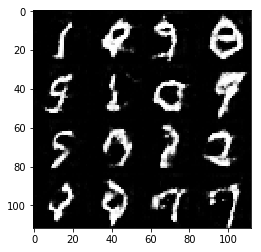

Epoch 1/2... Step 810 Discriminator Loss: 1.4734... Generator Loss: 0.4257
Epoch 1/2... Step 820 Discriminator Loss: 1.3099... Generator Loss: 0.6166
Epoch 1/2... Step 830 Discriminator Loss: 2.3634... Generator Loss: 0.1192
Epoch 1/2... Step 840 Discriminator Loss: 1.5118... Generator Loss: 0.3782
Epoch 1/2... Step 850 Discriminator Loss: 1.7286... Generator Loss: 0.2851
Epoch 1/2... Step 860 Discriminator Loss: 1.9218... Generator Loss: 0.2004
Epoch 1/2... Step 870 Discriminator Loss: 1.5605... Generator Loss: 0.3225
Epoch 1/2... Step 880 Discriminator Loss: 1.4415... Generator Loss: 0.4207
Epoch 1/2... Step 890 Discriminator Loss: 1.7387... Generator Loss: 0.4138
Epoch 1/2... Step 900 Discriminator Loss: 1.9719... Generator Loss: 0.2037


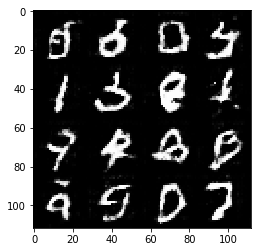

Epoch 1/2... Step 910 Discriminator Loss: 1.0821... Generator Loss: 0.8526
Epoch 1/2... Step 920 Discriminator Loss: 1.3362... Generator Loss: 0.4837
Epoch 1/2... Step 930 Discriminator Loss: 0.9122... Generator Loss: 0.7618
Epoch 2/2... Step 940 Discriminator Loss: 1.8633... Generator Loss: 0.2124
Epoch 2/2... Step 950 Discriminator Loss: 1.9311... Generator Loss: 0.2114
Epoch 2/2... Step 960 Discriminator Loss: 1.0363... Generator Loss: 2.0905
Epoch 2/2... Step 970 Discriminator Loss: 1.5093... Generator Loss: 0.3981
Epoch 2/2... Step 980 Discriminator Loss: 1.7847... Generator Loss: 0.2288
Epoch 2/2... Step 990 Discriminator Loss: 2.1935... Generator Loss: 0.1490
Epoch 2/2... Step 1000 Discriminator Loss: 1.5029... Generator Loss: 0.4369


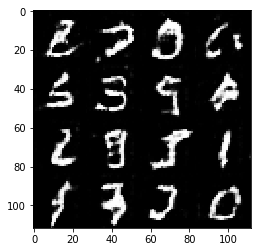

Epoch 2/2... Step 1010 Discriminator Loss: 1.3776... Generator Loss: 0.5014
Epoch 2/2... Step 1020 Discriminator Loss: 1.4311... Generator Loss: 0.4395
Epoch 2/2... Step 1030 Discriminator Loss: 1.7318... Generator Loss: 0.3157
Epoch 2/2... Step 1040 Discriminator Loss: 1.7713... Generator Loss: 0.3333
Epoch 2/2... Step 1050 Discriminator Loss: 2.8491... Generator Loss: 0.0701
Epoch 2/2... Step 1060 Discriminator Loss: 1.4115... Generator Loss: 0.4209
Epoch 2/2... Step 1070 Discriminator Loss: 1.8080... Generator Loss: 0.2683
Epoch 2/2... Step 1080 Discriminator Loss: 1.4474... Generator Loss: 0.4105
Epoch 2/2... Step 1090 Discriminator Loss: 1.9905... Generator Loss: 0.2335
Epoch 2/2... Step 1100 Discriminator Loss: 1.6865... Generator Loss: 0.3754


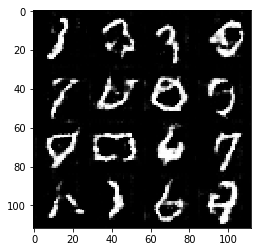

Epoch 2/2... Step 1110 Discriminator Loss: 1.4044... Generator Loss: 0.4395
Epoch 2/2... Step 1120 Discriminator Loss: 1.0647... Generator Loss: 0.6346
Epoch 2/2... Step 1130 Discriminator Loss: 2.3462... Generator Loss: 0.1252
Epoch 2/2... Step 1140 Discriminator Loss: 0.7322... Generator Loss: 1.1064
Epoch 2/2... Step 1150 Discriminator Loss: 2.5949... Generator Loss: 0.0933
Epoch 2/2... Step 1160 Discriminator Loss: 1.4012... Generator Loss: 0.8431
Epoch 2/2... Step 1170 Discriminator Loss: 1.7302... Generator Loss: 0.2463
Epoch 2/2... Step 1180 Discriminator Loss: 1.8000... Generator Loss: 0.2485
Epoch 2/2... Step 1190 Discriminator Loss: 1.7749... Generator Loss: 0.2483
Epoch 2/2... Step 1200 Discriminator Loss: 1.7775... Generator Loss: 0.2355


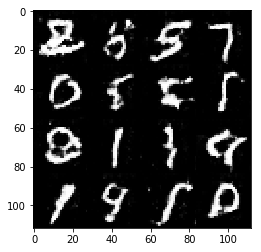

Epoch 2/2... Step 1210 Discriminator Loss: 1.4576... Generator Loss: 0.5056
Epoch 2/2... Step 1220 Discriminator Loss: 2.0463... Generator Loss: 0.1827
Epoch 2/2... Step 1230 Discriminator Loss: 1.7671... Generator Loss: 0.2694
Epoch 2/2... Step 1240 Discriminator Loss: 1.5019... Generator Loss: 0.3902
Epoch 2/2... Step 1250 Discriminator Loss: 2.1857... Generator Loss: 0.1564
Epoch 2/2... Step 1260 Discriminator Loss: 1.8469... Generator Loss: 0.2409
Epoch 2/2... Step 1270 Discriminator Loss: 1.3858... Generator Loss: 0.5217
Epoch 2/2... Step 1280 Discriminator Loss: 1.4939... Generator Loss: 0.5295
Epoch 2/2... Step 1290 Discriminator Loss: 2.4060... Generator Loss: 0.1288
Epoch 2/2... Step 1300 Discriminator Loss: 1.4739... Generator Loss: 0.4604


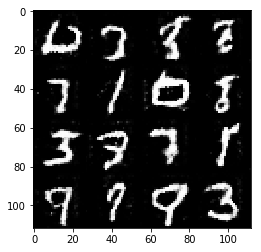

Epoch 2/2... Step 1310 Discriminator Loss: 1.7759... Generator Loss: 0.3455
Epoch 2/2... Step 1320 Discriminator Loss: 1.8851... Generator Loss: 0.2213
Epoch 2/2... Step 1330 Discriminator Loss: 1.9733... Generator Loss: 0.2270
Epoch 2/2... Step 1340 Discriminator Loss: 1.4993... Generator Loss: 0.4316
Epoch 2/2... Step 1350 Discriminator Loss: 1.3707... Generator Loss: 0.4563
Epoch 2/2... Step 1360 Discriminator Loss: 1.4792... Generator Loss: 0.3608
Epoch 2/2... Step 1370 Discriminator Loss: 1.8451... Generator Loss: 0.2397
Epoch 2/2... Step 1380 Discriminator Loss: 1.5927... Generator Loss: 0.3539
Epoch 2/2... Step 1390 Discriminator Loss: 1.9148... Generator Loss: 0.2098
Epoch 2/2... Step 1400 Discriminator Loss: 1.8078... Generator Loss: 0.2698


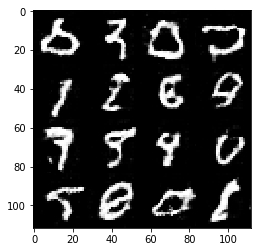

Epoch 2/2... Step 1410 Discriminator Loss: 1.1723... Generator Loss: 0.6692
Epoch 2/2... Step 1420 Discriminator Loss: 1.8516... Generator Loss: 0.2216
Epoch 2/2... Step 1430 Discriminator Loss: 1.7928... Generator Loss: 0.2653
Epoch 2/2... Step 1440 Discriminator Loss: 2.3769... Generator Loss: 0.1222
Epoch 2/2... Step 1450 Discriminator Loss: 2.0144... Generator Loss: 0.1902
Epoch 2/2... Step 1460 Discriminator Loss: 1.4910... Generator Loss: 0.3426
Epoch 2/2... Step 1470 Discriminator Loss: 1.8490... Generator Loss: 0.2309
Epoch 2/2... Step 1480 Discriminator Loss: 2.0417... Generator Loss: 0.2166
Epoch 2/2... Step 1490 Discriminator Loss: 1.1102... Generator Loss: 0.6358
Epoch 2/2... Step 1500 Discriminator Loss: 1.2973... Generator Loss: 0.4698


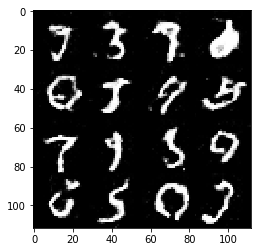

Epoch 2/2... Step 1510 Discriminator Loss: 1.5342... Generator Loss: 0.3627
Epoch 2/2... Step 1520 Discriminator Loss: 1.8440... Generator Loss: 0.2496
Epoch 2/2... Step 1530 Discriminator Loss: 1.6596... Generator Loss: 0.2888
Epoch 2/2... Step 1540 Discriminator Loss: 1.5156... Generator Loss: 0.3842
Epoch 2/2... Step 1550 Discriminator Loss: 1.5365... Generator Loss: 0.3494
Epoch 2/2... Step 1560 Discriminator Loss: 2.1932... Generator Loss: 0.1514
Epoch 2/2... Step 1570 Discriminator Loss: 1.4052... Generator Loss: 0.4317
Epoch 2/2... Step 1580 Discriminator Loss: 1.7332... Generator Loss: 0.3085
Epoch 2/2... Step 1590 Discriminator Loss: 1.3413... Generator Loss: 0.5264
Epoch 2/2... Step 1600 Discriminator Loss: 1.8185... Generator Loss: 0.2417


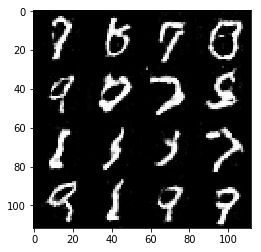

Epoch 2/2... Step 1610 Discriminator Loss: 1.5821... Generator Loss: 0.4092
Epoch 2/2... Step 1620 Discriminator Loss: 2.0936... Generator Loss: 0.1876
Epoch 2/2... Step 1630 Discriminator Loss: 1.4264... Generator Loss: 0.4190
Epoch 2/2... Step 1640 Discriminator Loss: 1.3272... Generator Loss: 0.5390
Epoch 2/2... Step 1650 Discriminator Loss: 1.6361... Generator Loss: 0.3328
Epoch 2/2... Step 1660 Discriminator Loss: 1.5989... Generator Loss: 0.3112
Epoch 2/2... Step 1670 Discriminator Loss: 1.7772... Generator Loss: 0.2808
Epoch 2/2... Step 1680 Discriminator Loss: 1.5524... Generator Loss: 0.4304
Epoch 2/2... Step 1690 Discriminator Loss: 2.7793... Generator Loss: 0.0832
Epoch 2/2... Step 1700 Discriminator Loss: 1.5727... Generator Loss: 0.3170


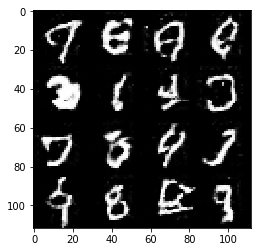

Epoch 2/2... Step 1710 Discriminator Loss: 1.4977... Generator Loss: 0.4117
Epoch 2/2... Step 1720 Discriminator Loss: 1.4168... Generator Loss: 0.4232
Epoch 2/2... Step 1730 Discriminator Loss: 1.2777... Generator Loss: 0.5757
Epoch 2/2... Step 1740 Discriminator Loss: 1.2350... Generator Loss: 0.5291
Epoch 2/2... Step 1750 Discriminator Loss: 2.1476... Generator Loss: 0.1709
Epoch 2/2... Step 1760 Discriminator Loss: 2.0495... Generator Loss: 0.1775
Epoch 2/2... Step 1770 Discriminator Loss: 1.7796... Generator Loss: 0.2719
Epoch 2/2... Step 1780 Discriminator Loss: 1.4030... Generator Loss: 0.3823
Epoch 2/2... Step 1790 Discriminator Loss: 2.0656... Generator Loss: 0.1766
Epoch 2/2... Step 1800 Discriminator Loss: 2.0192... Generator Loss: 0.1902


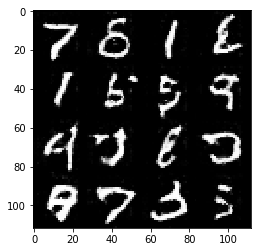

Epoch 2/2... Step 1810 Discriminator Loss: 1.7584... Generator Loss: 0.2638
Epoch 2/2... Step 1820 Discriminator Loss: 1.9689... Generator Loss: 0.1982
Epoch 2/2... Step 1830 Discriminator Loss: 1.6022... Generator Loss: 0.3347
Epoch 2/2... Step 1840 Discriminator Loss: 2.1917... Generator Loss: 0.1521
Epoch 2/2... Step 1850 Discriminator Loss: 1.4054... Generator Loss: 0.4677
Epoch 2/2... Step 1860 Discriminator Loss: 1.3427... Generator Loss: 0.4002
Epoch 2/2... Step 1870 Discriminator Loss: 1.6004... Generator Loss: 0.3201


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 Discriminator Loss: 4.8093... Generator Loss: 0.0201
Epoch 1/1... Step 20 Discriminator Loss: 3.7775... Generator Loss: 0.0554
Epoch 1/1... Step 30 Discriminator Loss: 3.3220... Generator Loss: 0.0987
Epoch 1/1... Step 40 Discriminator Loss: 3.0941... Generator Loss: 0.0951
Epoch 1/1... Step 50 Discriminator Loss: 2.3171... Generator Loss: 0.2891
Epoch 1/1... Step 60 Discriminator Loss: 2.5995... Generator Loss: 0.1979
Epoch 1/1... Step 70 Discriminator Loss: 2.7080... Generator Loss: 0.1922
Epoch 1/1... Step 80 Discriminator Loss: 2.4559... Generator Loss: 0.2343
Epoch 1/1... Step 90 Discriminator Loss: 2.3107... Generator Loss: 0.2749
Epoch 1/1... Step 100 Discriminator Loss: 2.1191... Generator Loss: 0.3325


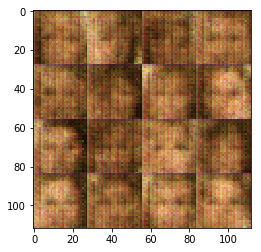

Epoch 1/1... Step 110 Discriminator Loss: 2.0332... Generator Loss: 0.3654
Epoch 1/1... Step 120 Discriminator Loss: 2.1267... Generator Loss: 0.3180
Epoch 1/1... Step 130 Discriminator Loss: 1.9871... Generator Loss: 0.3576
Epoch 1/1... Step 140 Discriminator Loss: 1.9055... Generator Loss: 0.4244
Epoch 1/1... Step 150 Discriminator Loss: 1.8971... Generator Loss: 0.3939
Epoch 1/1... Step 160 Discriminator Loss: 1.8013... Generator Loss: 0.4323
Epoch 1/1... Step 170 Discriminator Loss: 1.7174... Generator Loss: 0.5092
Epoch 1/1... Step 180 Discriminator Loss: 1.8292... Generator Loss: 0.4172
Epoch 1/1... Step 190 Discriminator Loss: 1.7185... Generator Loss: 0.4711
Epoch 1/1... Step 200 Discriminator Loss: 1.7537... Generator Loss: 0.4648


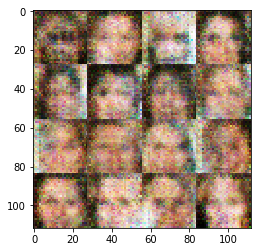

Epoch 1/1... Step 210 Discriminator Loss: 1.6699... Generator Loss: 0.5348
Epoch 1/1... Step 220 Discriminator Loss: 1.6751... Generator Loss: 0.5038
Epoch 1/1... Step 230 Discriminator Loss: 1.7343... Generator Loss: 0.4897
Epoch 1/1... Step 240 Discriminator Loss: 1.6513... Generator Loss: 0.5044
Epoch 1/1... Step 250 Discriminator Loss: 1.6400... Generator Loss: 0.5257
Epoch 1/1... Step 260 Discriminator Loss: 1.6459... Generator Loss: 0.5115
Epoch 1/1... Step 270 Discriminator Loss: 1.6834... Generator Loss: 0.5082
Epoch 1/1... Step 280 Discriminator Loss: 1.6378... Generator Loss: 0.5245
Epoch 1/1... Step 290 Discriminator Loss: 1.5992... Generator Loss: 0.5182
Epoch 1/1... Step 300 Discriminator Loss: 1.5732... Generator Loss: 0.5394


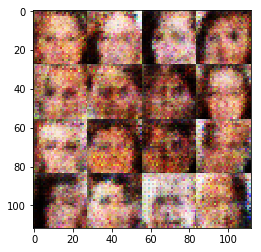

Epoch 1/1... Step 310 Discriminator Loss: 1.6113... Generator Loss: 0.5569
Epoch 1/1... Step 320 Discriminator Loss: 1.6383... Generator Loss: 0.5298
Epoch 1/1... Step 330 Discriminator Loss: 1.5933... Generator Loss: 0.5510
Epoch 1/1... Step 340 Discriminator Loss: 1.5810... Generator Loss: 0.5572
Epoch 1/1... Step 350 Discriminator Loss: 1.5981... Generator Loss: 0.5669
Epoch 1/1... Step 360 Discriminator Loss: 1.5745... Generator Loss: 0.5630
Epoch 1/1... Step 370 Discriminator Loss: 1.5387... Generator Loss: 0.5961
Epoch 1/1... Step 380 Discriminator Loss: 1.5959... Generator Loss: 0.5522
Epoch 1/1... Step 390 Discriminator Loss: 1.6230... Generator Loss: 0.5484
Epoch 1/1... Step 400 Discriminator Loss: 1.6107... Generator Loss: 0.5292


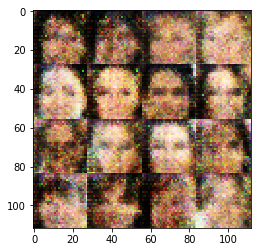

Epoch 1/1... Step 410 Discriminator Loss: 1.5336... Generator Loss: 0.5737
Epoch 1/1... Step 420 Discriminator Loss: 1.5796... Generator Loss: 0.5611
Epoch 1/1... Step 430 Discriminator Loss: 1.5277... Generator Loss: 0.5657
Epoch 1/1... Step 440 Discriminator Loss: 1.6118... Generator Loss: 0.5865
Epoch 1/1... Step 450 Discriminator Loss: 1.5928... Generator Loss: 0.5337
Epoch 1/1... Step 460 Discriminator Loss: 1.5553... Generator Loss: 0.5914
Epoch 1/1... Step 470 Discriminator Loss: 1.5981... Generator Loss: 0.5615
Epoch 1/1... Step 480 Discriminator Loss: 1.5614... Generator Loss: 0.5665
Epoch 1/1... Step 490 Discriminator Loss: 1.5518... Generator Loss: 0.5875
Epoch 1/1... Step 500 Discriminator Loss: 1.5597... Generator Loss: 0.5893


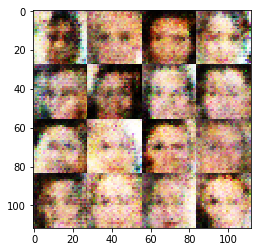

Epoch 1/1... Step 510 Discriminator Loss: 1.5586... Generator Loss: 0.5821
Epoch 1/1... Step 520 Discriminator Loss: 1.5454... Generator Loss: 0.5806
Epoch 1/1... Step 530 Discriminator Loss: 1.5063... Generator Loss: 0.5735
Epoch 1/1... Step 540 Discriminator Loss: 1.5550... Generator Loss: 0.5695
Epoch 1/1... Step 550 Discriminator Loss: 1.5649... Generator Loss: 0.5710
Epoch 1/1... Step 560 Discriminator Loss: 1.5371... Generator Loss: 0.5928
Epoch 1/1... Step 570 Discriminator Loss: 1.5116... Generator Loss: 0.6008
Epoch 1/1... Step 580 Discriminator Loss: 1.5612... Generator Loss: 0.5974
Epoch 1/1... Step 590 Discriminator Loss: 1.5138... Generator Loss: 0.5969
Epoch 1/1... Step 600 Discriminator Loss: 1.4974... Generator Loss: 0.6128


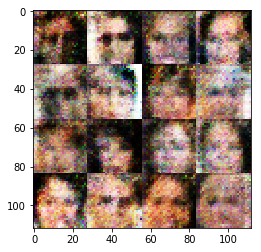

Epoch 1/1... Step 610 Discriminator Loss: 1.5010... Generator Loss: 0.6197
Epoch 1/1... Step 620 Discriminator Loss: 1.4892... Generator Loss: 0.6099
Epoch 1/1... Step 630 Discriminator Loss: 1.4905... Generator Loss: 0.5971
Epoch 1/1... Step 640 Discriminator Loss: 1.4838... Generator Loss: 0.6168
Epoch 1/1... Step 650 Discriminator Loss: 1.4732... Generator Loss: 0.6175
Epoch 1/1... Step 660 Discriminator Loss: 1.5343... Generator Loss: 0.5960
Epoch 1/1... Step 670 Discriminator Loss: 1.5264... Generator Loss: 0.5854
Epoch 1/1... Step 680 Discriminator Loss: 1.4819... Generator Loss: 0.6111
Epoch 1/1... Step 690 Discriminator Loss: 1.4969... Generator Loss: 0.6233
Epoch 1/1... Step 700 Discriminator Loss: 1.5131... Generator Loss: 0.6215


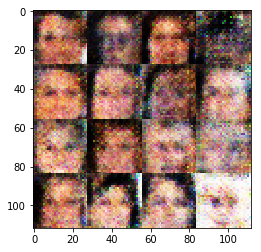

Epoch 1/1... Step 710 Discriminator Loss: 1.4677... Generator Loss: 0.6109
Epoch 1/1... Step 720 Discriminator Loss: 1.5240... Generator Loss: 0.5945
Epoch 1/1... Step 730 Discriminator Loss: 1.5335... Generator Loss: 0.5754
Epoch 1/1... Step 740 Discriminator Loss: 1.5031... Generator Loss: 0.6020
Epoch 1/1... Step 750 Discriminator Loss: 1.4498... Generator Loss: 0.6449
Epoch 1/1... Step 760 Discriminator Loss: 1.4945... Generator Loss: 0.6381
Epoch 1/1... Step 770 Discriminator Loss: 1.5128... Generator Loss: 0.6053
Epoch 1/1... Step 780 Discriminator Loss: 1.5439... Generator Loss: 0.6038
Epoch 1/1... Step 790 Discriminator Loss: 1.4976... Generator Loss: 0.5744
Epoch 1/1... Step 800 Discriminator Loss: 1.5348... Generator Loss: 0.5883


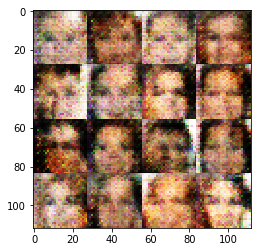

Epoch 1/1... Step 810 Discriminator Loss: 1.4936... Generator Loss: 0.6337
Epoch 1/1... Step 820 Discriminator Loss: 1.5554... Generator Loss: 0.5904
Epoch 1/1... Step 830 Discriminator Loss: 1.5457... Generator Loss: 0.5808
Epoch 1/1... Step 840 Discriminator Loss: 1.5250... Generator Loss: 0.5837
Epoch 1/1... Step 850 Discriminator Loss: 1.4619... Generator Loss: 0.6325
Epoch 1/1... Step 860 Discriminator Loss: 1.5176... Generator Loss: 0.6037
Epoch 1/1... Step 870 Discriminator Loss: 1.5267... Generator Loss: 0.6006
Epoch 1/1... Step 880 Discriminator Loss: 1.4992... Generator Loss: 0.5998
Epoch 1/1... Step 890 Discriminator Loss: 1.4764... Generator Loss: 0.6271
Epoch 1/1... Step 900 Discriminator Loss: 1.4754... Generator Loss: 0.6479


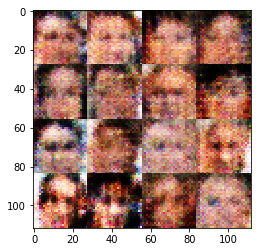

Epoch 1/1... Step 910 Discriminator Loss: 1.4449... Generator Loss: 0.6398
Epoch 1/1... Step 920 Discriminator Loss: 1.4852... Generator Loss: 0.6157
Epoch 1/1... Step 930 Discriminator Loss: 1.4754... Generator Loss: 0.6402
Epoch 1/1... Step 940 Discriminator Loss: 1.4647... Generator Loss: 0.6443
Epoch 1/1... Step 950 Discriminator Loss: 1.4742... Generator Loss: 0.6138
Epoch 1/1... Step 960 Discriminator Loss: 1.4908... Generator Loss: 0.6182
Epoch 1/1... Step 970 Discriminator Loss: 1.4910... Generator Loss: 0.6140
Epoch 1/1... Step 980 Discriminator Loss: 1.4481... Generator Loss: 0.6177
Epoch 1/1... Step 990 Discriminator Loss: 1.4611... Generator Loss: 0.6496
Epoch 1/1... Step 1000 Discriminator Loss: 1.5013... Generator Loss: 0.6169


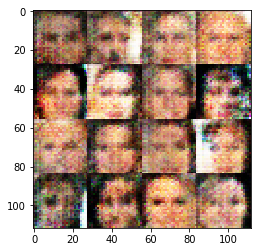

Epoch 1/1... Step 1010 Discriminator Loss: 1.4508... Generator Loss: 0.6300
Epoch 1/1... Step 1020 Discriminator Loss: 1.4433... Generator Loss: 0.6483
Epoch 1/1... Step 1030 Discriminator Loss: 1.4711... Generator Loss: 0.6492
Epoch 1/1... Step 1040 Discriminator Loss: 1.4932... Generator Loss: 0.6276
Epoch 1/1... Step 1050 Discriminator Loss: 1.5053... Generator Loss: 0.6014
Epoch 1/1... Step 1060 Discriminator Loss: 1.4758... Generator Loss: 0.6202
Epoch 1/1... Step 1070 Discriminator Loss: 1.4631... Generator Loss: 0.6480
Epoch 1/1... Step 1080 Discriminator Loss: 1.4885... Generator Loss: 0.6230
Epoch 1/1... Step 1090 Discriminator Loss: 1.4571... Generator Loss: 0.6710
Epoch 1/1... Step 1100 Discriminator Loss: 1.5138... Generator Loss: 0.6225


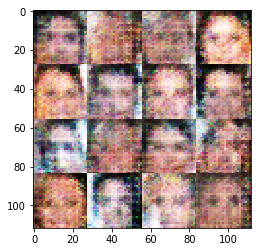

Epoch 1/1... Step 1110 Discriminator Loss: 1.4750... Generator Loss: 0.6431
Epoch 1/1... Step 1120 Discriminator Loss: 1.4520... Generator Loss: 0.6403
Epoch 1/1... Step 1130 Discriminator Loss: 1.4461... Generator Loss: 0.6194
Epoch 1/1... Step 1140 Discriminator Loss: 1.4620... Generator Loss: 0.6497
Epoch 1/1... Step 1150 Discriminator Loss: 1.5180... Generator Loss: 0.5810
Epoch 1/1... Step 1160 Discriminator Loss: 1.4626... Generator Loss: 0.6347
Epoch 1/1... Step 1170 Discriminator Loss: 1.4685... Generator Loss: 0.6440
Epoch 1/1... Step 1180 Discriminator Loss: 1.4762... Generator Loss: 0.6013
Epoch 1/1... Step 1190 Discriminator Loss: 1.4612... Generator Loss: 0.6603
Epoch 1/1... Step 1200 Discriminator Loss: 1.4580... Generator Loss: 0.6532


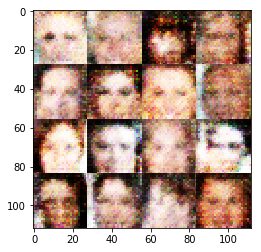

Epoch 1/1... Step 1210 Discriminator Loss: 1.4529... Generator Loss: 0.6431
Epoch 1/1... Step 1220 Discriminator Loss: 1.4338... Generator Loss: 0.6667
Epoch 1/1... Step 1230 Discriminator Loss: 1.4928... Generator Loss: 0.6254
Epoch 1/1... Step 1240 Discriminator Loss: 1.4704... Generator Loss: 0.6306
Epoch 1/1... Step 1250 Discriminator Loss: 1.5109... Generator Loss: 0.6125
Epoch 1/1... Step 1260 Discriminator Loss: 1.4413... Generator Loss: 0.6587
Epoch 1/1... Step 1270 Discriminator Loss: 1.4744... Generator Loss: 0.5929
Epoch 1/1... Step 1280 Discriminator Loss: 1.4286... Generator Loss: 0.6377
Epoch 1/1... Step 1290 Discriminator Loss: 1.4672... Generator Loss: 0.6393
Epoch 1/1... Step 1300 Discriminator Loss: 1.4726... Generator Loss: 0.6483


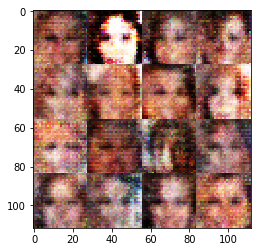

Epoch 1/1... Step 1310 Discriminator Loss: 1.4655... Generator Loss: 0.6542
Epoch 1/1... Step 1320 Discriminator Loss: 1.4171... Generator Loss: 0.6678
Epoch 1/1... Step 1330 Discriminator Loss: 1.4677... Generator Loss: 0.6364
Epoch 1/1... Step 1340 Discriminator Loss: 1.5112... Generator Loss: 0.5837
Epoch 1/1... Step 1350 Discriminator Loss: 1.4587... Generator Loss: 0.6179
Epoch 1/1... Step 1360 Discriminator Loss: 1.4609... Generator Loss: 0.6555
Epoch 1/1... Step 1370 Discriminator Loss: 1.4845... Generator Loss: 0.6169
Epoch 1/1... Step 1380 Discriminator Loss: 1.4306... Generator Loss: 0.6743
Epoch 1/1... Step 1390 Discriminator Loss: 1.4816... Generator Loss: 0.6201
Epoch 1/1... Step 1400 Discriminator Loss: 1.4889... Generator Loss: 0.6079


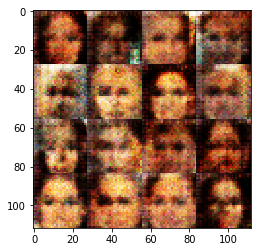

Epoch 1/1... Step 1410 Discriminator Loss: 1.4551... Generator Loss: 0.6280
Epoch 1/1... Step 1420 Discriminator Loss: 1.4360... Generator Loss: 0.6525
Epoch 1/1... Step 1430 Discriminator Loss: 1.4339... Generator Loss: 0.6251
Epoch 1/1... Step 1440 Discriminator Loss: 1.4363... Generator Loss: 0.6359
Epoch 1/1... Step 1450 Discriminator Loss: 1.4536... Generator Loss: 0.6616
Epoch 1/1... Step 1460 Discriminator Loss: 1.4905... Generator Loss: 0.6489
Epoch 1/1... Step 1470 Discriminator Loss: 1.4485... Generator Loss: 0.6265
Epoch 1/1... Step 1480 Discriminator Loss: 1.4455... Generator Loss: 0.6504
Epoch 1/1... Step 1490 Discriminator Loss: 1.4644... Generator Loss: 0.6271
Epoch 1/1... Step 1500 Discriminator Loss: 1.4311... Generator Loss: 0.6745


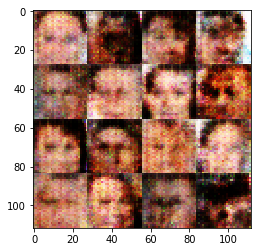

Epoch 1/1... Step 1510 Discriminator Loss: 1.4713... Generator Loss: 0.6525
Epoch 1/1... Step 1520 Discriminator Loss: 1.4295... Generator Loss: 0.6497
Epoch 1/1... Step 1530 Discriminator Loss: 1.4389... Generator Loss: 0.6464
Epoch 1/1... Step 1540 Discriminator Loss: 1.4591... Generator Loss: 0.6386
Epoch 1/1... Step 1550 Discriminator Loss: 1.4740... Generator Loss: 0.6343
Epoch 1/1... Step 1560 Discriminator Loss: 1.4881... Generator Loss: 0.6219
Epoch 1/1... Step 1570 Discriminator Loss: 1.4594... Generator Loss: 0.6263
Epoch 1/1... Step 1580 Discriminator Loss: 1.4219... Generator Loss: 0.6793
Epoch 1/1... Step 1590 Discriminator Loss: 1.4279... Generator Loss: 0.6429
Epoch 1/1... Step 1600 Discriminator Loss: 1.4283... Generator Loss: 0.6730


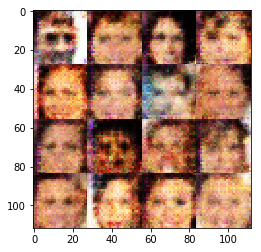

Epoch 1/1... Step 1610 Discriminator Loss: 1.4527... Generator Loss: 0.6639
Epoch 1/1... Step 1620 Discriminator Loss: 1.4587... Generator Loss: 0.6192
Epoch 1/1... Step 1630 Discriminator Loss: 1.4623... Generator Loss: 0.6322
Epoch 1/1... Step 1640 Discriminator Loss: 1.4658... Generator Loss: 0.6303
Epoch 1/1... Step 1650 Discriminator Loss: 1.5048... Generator Loss: 0.6161
Epoch 1/1... Step 1660 Discriminator Loss: 1.4407... Generator Loss: 0.6294
Epoch 1/1... Step 1670 Discriminator Loss: 1.4275... Generator Loss: 0.6684
Epoch 1/1... Step 1680 Discriminator Loss: 1.4531... Generator Loss: 0.6211
Epoch 1/1... Step 1690 Discriminator Loss: 1.4755... Generator Loss: 0.6396
Epoch 1/1... Step 1700 Discriminator Loss: 1.4560... Generator Loss: 0.6326


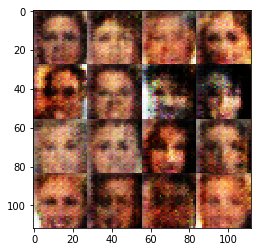

Epoch 1/1... Step 1710 Discriminator Loss: 1.4369... Generator Loss: 0.6341
Epoch 1/1... Step 1720 Discriminator Loss: 1.4177... Generator Loss: 0.6593
Epoch 1/1... Step 1730 Discriminator Loss: 1.4888... Generator Loss: 0.6090
Epoch 1/1... Step 1740 Discriminator Loss: 1.4911... Generator Loss: 0.6362
Epoch 1/1... Step 1750 Discriminator Loss: 1.4763... Generator Loss: 0.6355
Epoch 1/1... Step 1760 Discriminator Loss: 1.4806... Generator Loss: 0.6152
Epoch 1/1... Step 1770 Discriminator Loss: 1.4913... Generator Loss: 0.6207
Epoch 1/1... Step 1780 Discriminator Loss: 1.4979... Generator Loss: 0.6056
Epoch 1/1... Step 1790 Discriminator Loss: 1.4282... Generator Loss: 0.6348
Epoch 1/1... Step 1800 Discriminator Loss: 1.4366... Generator Loss: 0.6489


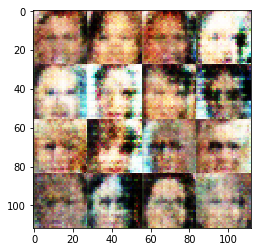

Epoch 1/1... Step 1810 Discriminator Loss: 1.4106... Generator Loss: 0.6634
Epoch 1/1... Step 1820 Discriminator Loss: 1.4655... Generator Loss: 0.6421
Epoch 1/1... Step 1830 Discriminator Loss: 1.4265... Generator Loss: 0.6571
Epoch 1/1... Step 1840 Discriminator Loss: 1.4335... Generator Loss: 0.6547
Epoch 1/1... Step 1850 Discriminator Loss: 1.3901... Generator Loss: 0.6957
Epoch 1/1... Step 1860 Discriminator Loss: 1.4554... Generator Loss: 0.6372
Epoch 1/1... Step 1870 Discriminator Loss: 1.4418... Generator Loss: 0.6650
Epoch 1/1... Step 1880 Discriminator Loss: 1.4531... Generator Loss: 0.6431
Epoch 1/1... Step 1890 Discriminator Loss: 1.4476... Generator Loss: 0.6309
Epoch 1/1... Step 1900 Discriminator Loss: 1.4354... Generator Loss: 0.6324


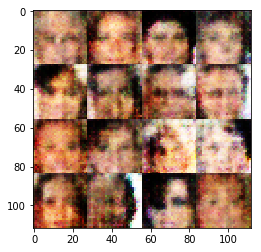

Epoch 1/1... Step 1910 Discriminator Loss: 1.4506... Generator Loss: 0.6729
Epoch 1/1... Step 1920 Discriminator Loss: 1.4271... Generator Loss: 0.6516
Epoch 1/1... Step 1930 Discriminator Loss: 1.4396... Generator Loss: 0.6641
Epoch 1/1... Step 1940 Discriminator Loss: 1.4397... Generator Loss: 0.6490
Epoch 1/1... Step 1950 Discriminator Loss: 1.4357... Generator Loss: 0.6464
Epoch 1/1... Step 1960 Discriminator Loss: 1.4539... Generator Loss: 0.6489
Epoch 1/1... Step 1970 Discriminator Loss: 1.4669... Generator Loss: 0.6420
Epoch 1/1... Step 1980 Discriminator Loss: 1.4277... Generator Loss: 0.6778
Epoch 1/1... Step 1990 Discriminator Loss: 1.4309... Generator Loss: 0.6532
Epoch 1/1... Step 2000 Discriminator Loss: 1.4224... Generator Loss: 0.6606


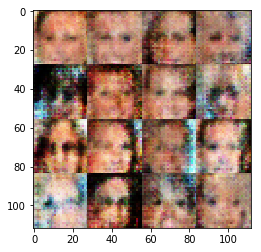

Epoch 1/1... Step 2010 Discriminator Loss: 1.4401... Generator Loss: 0.6543
Epoch 1/1... Step 2020 Discriminator Loss: 1.4335... Generator Loss: 0.6610
Epoch 1/1... Step 2030 Discriminator Loss: 1.4215... Generator Loss: 0.6507
Epoch 1/1... Step 2040 Discriminator Loss: 1.4424... Generator Loss: 0.6792
Epoch 1/1... Step 2050 Discriminator Loss: 1.4421... Generator Loss: 0.6319
Epoch 1/1... Step 2060 Discriminator Loss: 1.4656... Generator Loss: 0.6404
Epoch 1/1... Step 2070 Discriminator Loss: 1.4795... Generator Loss: 0.6519
Epoch 1/1... Step 2080 Discriminator Loss: 1.4779... Generator Loss: 0.6081
Epoch 1/1... Step 2090 Discriminator Loss: 1.4533... Generator Loss: 0.6370
Epoch 1/1... Step 2100 Discriminator Loss: 1.4538... Generator Loss: 0.6474


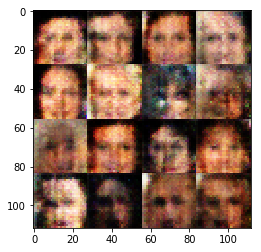

Epoch 1/1... Step 2110 Discriminator Loss: 1.4689... Generator Loss: 0.6224
Epoch 1/1... Step 2120 Discriminator Loss: 1.4081... Generator Loss: 0.6707
Epoch 1/1... Step 2130 Discriminator Loss: 1.4492... Generator Loss: 0.6381
Epoch 1/1... Step 2140 Discriminator Loss: 1.4285... Generator Loss: 0.6628
Epoch 1/1... Step 2150 Discriminator Loss: 1.4414... Generator Loss: 0.6644
Epoch 1/1... Step 2160 Discriminator Loss: 1.4679... Generator Loss: 0.6108
Epoch 1/1... Step 2170 Discriminator Loss: 1.4101... Generator Loss: 0.6455
Epoch 1/1... Step 2180 Discriminator Loss: 1.4539... Generator Loss: 0.6293
Epoch 1/1... Step 2190 Discriminator Loss: 1.4338... Generator Loss: 0.6434
Epoch 1/1... Step 2200 Discriminator Loss: 1.4063... Generator Loss: 0.6451


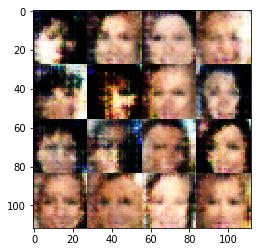

Epoch 1/1... Step 2210 Discriminator Loss: 1.4262... Generator Loss: 0.6480
Epoch 1/1... Step 2220 Discriminator Loss: 1.4664... Generator Loss: 0.6489
Epoch 1/1... Step 2230 Discriminator Loss: 1.4468... Generator Loss: 0.6485
Epoch 1/1... Step 2240 Discriminator Loss: 1.4496... Generator Loss: 0.6393
Epoch 1/1... Step 2250 Discriminator Loss: 1.4218... Generator Loss: 0.6401
Epoch 1/1... Step 2260 Discriminator Loss: 1.4509... Generator Loss: 0.6763
Epoch 1/1... Step 2270 Discriminator Loss: 1.4264... Generator Loss: 0.6492
Epoch 1/1... Step 2280 Discriminator Loss: 1.4451... Generator Loss: 0.6556
Epoch 1/1... Step 2290 Discriminator Loss: 1.4366... Generator Loss: 0.6557
Epoch 1/1... Step 2300 Discriminator Loss: 1.4329... Generator Loss: 0.6369


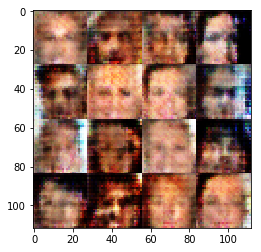

Epoch 1/1... Step 2310 Discriminator Loss: 1.4464... Generator Loss: 0.6454
Epoch 1/1... Step 2320 Discriminator Loss: 1.5021... Generator Loss: 0.6101
Epoch 1/1... Step 2330 Discriminator Loss: 1.4870... Generator Loss: 0.5866
Epoch 1/1... Step 2340 Discriminator Loss: 1.4654... Generator Loss: 0.6483
Epoch 1/1... Step 2350 Discriminator Loss: 1.4313... Generator Loss: 0.6539
Epoch 1/1... Step 2360 Discriminator Loss: 1.4194... Generator Loss: 0.6596
Epoch 1/1... Step 2370 Discriminator Loss: 1.4563... Generator Loss: 0.6415
Epoch 1/1... Step 2380 Discriminator Loss: 1.4747... Generator Loss: 0.6289
Epoch 1/1... Step 2390 Discriminator Loss: 1.4398... Generator Loss: 0.6136
Epoch 1/1... Step 2400 Discriminator Loss: 1.4330... Generator Loss: 0.6846


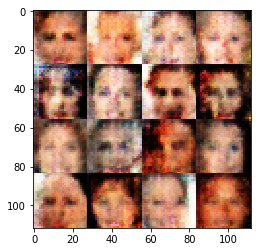

Epoch 1/1... Step 2410 Discriminator Loss: 1.4328... Generator Loss: 0.6633
Epoch 1/1... Step 2420 Discriminator Loss: 1.4319... Generator Loss: 0.6690
Epoch 1/1... Step 2430 Discriminator Loss: 1.4330... Generator Loss: 0.6681
Epoch 1/1... Step 2440 Discriminator Loss: 1.4385... Generator Loss: 0.6387
Epoch 1/1... Step 2450 Discriminator Loss: 1.4520... Generator Loss: 0.6392
Epoch 1/1... Step 2460 Discriminator Loss: 1.4540... Generator Loss: 0.6575
Epoch 1/1... Step 2470 Discriminator Loss: 1.4542... Generator Loss: 0.6408
Epoch 1/1... Step 2480 Discriminator Loss: 1.4649... Generator Loss: 0.6472
Epoch 1/1... Step 2490 Discriminator Loss: 1.4549... Generator Loss: 0.6508
Epoch 1/1... Step 2500 Discriminator Loss: 1.4483... Generator Loss: 0.6792


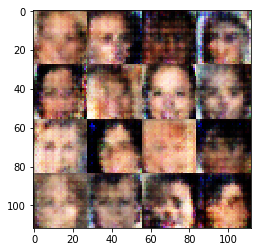

Epoch 1/1... Step 2510 Discriminator Loss: 1.4635... Generator Loss: 0.6262
Epoch 1/1... Step 2520 Discriminator Loss: 1.4465... Generator Loss: 0.6490
Epoch 1/1... Step 2530 Discriminator Loss: 1.4301... Generator Loss: 0.6592
Epoch 1/1... Step 2540 Discriminator Loss: 1.4463... Generator Loss: 0.6413
Epoch 1/1... Step 2550 Discriminator Loss: 1.4358... Generator Loss: 0.6566
Epoch 1/1... Step 2560 Discriminator Loss: 1.3904... Generator Loss: 0.7439
Epoch 1/1... Step 2570 Discriminator Loss: 1.4643... Generator Loss: 0.6311
Epoch 1/1... Step 2580 Discriminator Loss: 1.4500... Generator Loss: 0.6596
Epoch 1/1... Step 2590 Discriminator Loss: 1.4402... Generator Loss: 0.6510
Epoch 1/1... Step 2600 Discriminator Loss: 1.4700... Generator Loss: 0.5991


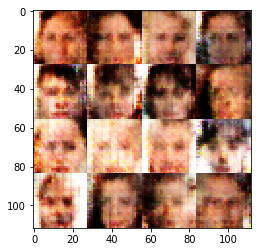

Epoch 1/1... Step 2610 Discriminator Loss: 1.4296... Generator Loss: 0.6938
Epoch 1/1... Step 2620 Discriminator Loss: 1.4221... Generator Loss: 0.6636
Epoch 1/1... Step 2630 Discriminator Loss: 1.4547... Generator Loss: 0.6087
Epoch 1/1... Step 2640 Discriminator Loss: 1.4560... Generator Loss: 0.6382
Epoch 1/1... Step 2650 Discriminator Loss: 1.4414... Generator Loss: 0.6586
Epoch 1/1... Step 2660 Discriminator Loss: 1.4186... Generator Loss: 0.6680
Epoch 1/1... Step 2670 Discriminator Loss: 1.4203... Generator Loss: 0.6513
Epoch 1/1... Step 2680 Discriminator Loss: 1.4135... Generator Loss: 0.6691
Epoch 1/1... Step 2690 Discriminator Loss: 1.4150... Generator Loss: 0.6502
Epoch 1/1... Step 2700 Discriminator Loss: 1.4348... Generator Loss: 0.6508


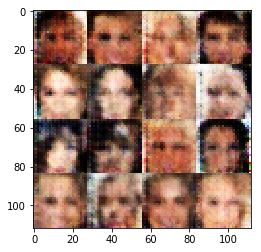

Epoch 1/1... Step 2710 Discriminator Loss: 1.4307... Generator Loss: 0.6614
Epoch 1/1... Step 2720 Discriminator Loss: 1.4219... Generator Loss: 0.6643
Epoch 1/1... Step 2730 Discriminator Loss: 1.4473... Generator Loss: 0.6672
Epoch 1/1... Step 2740 Discriminator Loss: 1.4397... Generator Loss: 0.6302
Epoch 1/1... Step 2750 Discriminator Loss: 1.4194... Generator Loss: 0.6691
Epoch 1/1... Step 2760 Discriminator Loss: 1.4047... Generator Loss: 0.6678
Epoch 1/1... Step 2770 Discriminator Loss: 1.4240... Generator Loss: 0.6550
Epoch 1/1... Step 2780 Discriminator Loss: 1.4279... Generator Loss: 0.6590
Epoch 1/1... Step 2790 Discriminator Loss: 1.4436... Generator Loss: 0.6447
Epoch 1/1... Step 2800 Discriminator Loss: 1.4303... Generator Loss: 0.6628


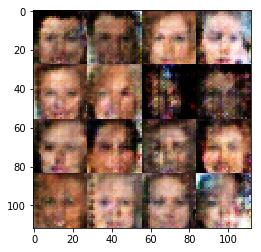

Epoch 1/1... Step 2810 Discriminator Loss: 1.4423... Generator Loss: 0.6259
Epoch 1/1... Step 2820 Discriminator Loss: 1.4524... Generator Loss: 0.6475
Epoch 1/1... Step 2830 Discriminator Loss: 1.4350... Generator Loss: 0.6566
Epoch 1/1... Step 2840 Discriminator Loss: 1.4411... Generator Loss: 0.6504
Epoch 1/1... Step 2850 Discriminator Loss: 1.4300... Generator Loss: 0.6526
Epoch 1/1... Step 2860 Discriminator Loss: 1.4146... Generator Loss: 0.6491
Epoch 1/1... Step 2870 Discriminator Loss: 1.4408... Generator Loss: 0.6642
Epoch 1/1... Step 2880 Discriminator Loss: 1.4602... Generator Loss: 0.6608
Epoch 1/1... Step 2890 Discriminator Loss: 1.4470... Generator Loss: 0.6299
Epoch 1/1... Step 2900 Discriminator Loss: 1.4382... Generator Loss: 0.6704


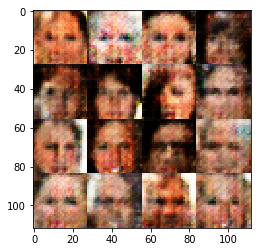

Epoch 1/1... Step 2910 Discriminator Loss: 1.4441... Generator Loss: 0.6368
Epoch 1/1... Step 2920 Discriminator Loss: 1.4883... Generator Loss: 0.6262
Epoch 1/1... Step 2930 Discriminator Loss: 1.4645... Generator Loss: 0.6278
Epoch 1/1... Step 2940 Discriminator Loss: 1.4317... Generator Loss: 0.6562
Epoch 1/1... Step 2950 Discriminator Loss: 1.4517... Generator Loss: 0.6184
Epoch 1/1... Step 2960 Discriminator Loss: 1.4249... Generator Loss: 0.6541
Epoch 1/1... Step 2970 Discriminator Loss: 1.4155... Generator Loss: 0.6577
Epoch 1/1... Step 2980 Discriminator Loss: 1.4333... Generator Loss: 0.6521
Epoch 1/1... Step 2990 Discriminator Loss: 1.4131... Generator Loss: 0.6493
Epoch 1/1... Step 3000 Discriminator Loss: 1.4224... Generator Loss: 0.6730


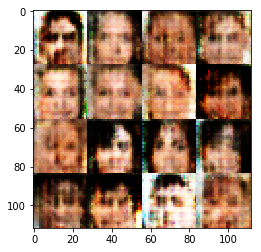

Epoch 1/1... Step 3010 Discriminator Loss: 1.4349... Generator Loss: 0.6539
Epoch 1/1... Step 3020 Discriminator Loss: 1.4862... Generator Loss: 0.6291
Epoch 1/1... Step 3030 Discriminator Loss: 1.4508... Generator Loss: 0.6418
Epoch 1/1... Step 3040 Discriminator Loss: 1.4412... Generator Loss: 0.6513
Epoch 1/1... Step 3050 Discriminator Loss: 1.4260... Generator Loss: 0.6815
Epoch 1/1... Step 3060 Discriminator Loss: 1.4106... Generator Loss: 0.6732
Epoch 1/1... Step 3070 Discriminator Loss: 1.4202... Generator Loss: 0.6713
Epoch 1/1... Step 3080 Discriminator Loss: 1.4404... Generator Loss: 0.6576
Epoch 1/1... Step 3090 Discriminator Loss: 1.4224... Generator Loss: 0.6659
Epoch 1/1... Step 3100 Discriminator Loss: 1.4276... Generator Loss: 0.6664


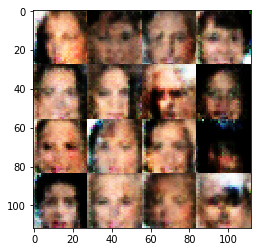

Epoch 1/1... Step 3110 Discriminator Loss: 1.4160... Generator Loss: 0.6871
Epoch 1/1... Step 3120 Discriminator Loss: 1.4470... Generator Loss: 0.6482
Epoch 1/1... Step 3130 Discriminator Loss: 1.4262... Generator Loss: 0.6575
Epoch 1/1... Step 3140 Discriminator Loss: 1.4214... Generator Loss: 0.6440
Epoch 1/1... Step 3150 Discriminator Loss: 1.4293... Generator Loss: 0.6632
Epoch 1/1... Step 3160 Discriminator Loss: 1.4169... Generator Loss: 0.6749


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.